# ResNet Encoder + Unet Decoder

## Data loader

In [1]:
import os
import cv2
import torch
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CrackDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transforms=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.images = os.listdir(image_dir)
        self.transforms = transforms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])  # assumes same filename

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Normalize mask to {0,1}
        mask = (mask > 127).astype("float32")

        if self.transforms:
            augmented = self.transforms(image=image, mask=mask)
            image, mask = augmented["image"], augmented["mask"]

        return image, mask.unsqueeze(0)  # (1,H,W) for mask


## Transforms

In [2]:
train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(),
    ToTensorV2(),
])

val_transforms = A.Compose([
    A.Normalize(),
    ToTensorV2(),
])


## Model

In [3]:
import segmentation_models_pytorch as smp

# Define model
model = smp.Unet(
    encoder_name="resnet101",        # choose encoder
    encoder_weights="imagenet",      # use pretrained ImageNet weights
    in_channels=3,                   # RGB images
    classes=1,                       # binary segmentation (crack / no crack)
)


## Loss & Metrics

In [4]:
import torch.nn as nn
from torchmetrics.segmentation import DiceScore

bce_loss = nn.BCEWithLogitsLoss()
dice_loss = smp.losses.DiceLoss(mode=smp.losses.BINARY_MODE, from_logits=True)

def combined_loss(pred, target):
    """Mix BCE and Dice loss for better stability."""
    return 0.5 * bce_loss(pred, target) + 0.5 * dice_loss(pred, target)

# Metric
dice_metric = DiceScore(
    num_classes=2,        # background + crack
    average="micro",      # aggregate across batch
    input_format="index"  # expects integer mask
)


/home/devpc/.local/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: DiceScore metric currently defaults to `average=micro`, but will change to`average=macro` in the v1.9 release. If you've explicitly set this parameter, you can ignore this warning.
  warnings.warn(*args, **kwargs)


## Training and Validation Loop

In [5]:
from torch.utils.data import DataLoader
from tqdm import tqdm

# Datasets
train_dataset = CrackDataset("train/images", "train/masks", transforms=train_transforms)
val_dataset   = CrackDataset("test/images", "test/masks", transforms=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=8)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
dice_metric = dice_metric.to(device)


## Validation Loop

In [6]:
EPOCHS = 50
os.makedirs("checkpoints", exist_ok=True)

for epoch in range(EPOCHS):
    # ---- Train ----
    model.train()
    train_loss = 0
    for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]"):
        imgs, masks = imgs.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = combined_loss(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # ---- Validation ----
    model.eval()
    val_loss = 0
    dice_metric.reset()

    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)

            outputs = model(imgs)
            loss = combined_loss(outputs, masks)
            val_loss += loss.item()

            preds = (torch.sigmoid(outputs) > 0.5).long().squeeze(1)   # (N,H,W)
            targets = masks.long().squeeze(1)                          # (N,H,W)
            dice_metric.update(preds, targets)

    val_dice = dice_metric.compute()

    print(f"Epoch {epoch+1}: "
          f"Train Loss={train_loss/len(train_loader):.4f}, "
          f"Val Loss={val_loss/len(val_loader):.4f}, "
          f"Val Dice={val_dice:.4f}")

    # ---- Save checkpoint every 5 epochs ----
    if (epoch + 1) % 5 == 0:
        ckpt_path = f"checkpoints/model_epoch_{epoch+1}.pth"
        torch.save(model.state_dict(), ckpt_path)
        print(f"✅ Saved checkpoint: {ckpt_path}")

# ---- Save final model ----
final_path = "checkpoints/model_final.pth"
torch.save(model.state_dict(), final_path)
print(f"\n🎉 Training complete! Final model saved at: {final_path}")

Epoch 1/50 [Train]: 100%|█| 1201/1201 [08:32<00:00,  2.


Epoch 1: Train Loss=0.4446, Val Loss=0.2648, Val Dice=0.9762


Epoch 2/50 [Train]: 100%|█| 1201/1201 [08:20<00:00,  2.


Epoch 2: Train Loss=0.2226, Val Loss=0.2129, Val Dice=0.9776


Epoch 3/50 [Train]: 100%|█| 1201/1201 [08:21<00:00,  2.


Epoch 3: Train Loss=0.2019, Val Loss=0.2089, Val Dice=0.9777


Epoch 4/50 [Train]: 100%|█| 1201/1201 [08:20<00:00,  2.


Epoch 4: Train Loss=0.1938, Val Loss=0.1879, Val Dice=0.9802


Epoch 5/50 [Train]: 100%|█| 1201/1201 [08:20<00:00,  2.


Epoch 5: Train Loss=0.1897, Val Loss=0.1784, Val Dice=0.9818
✅ Saved checkpoint: checkpoints/model_epoch_5.pth


Epoch 6/50 [Train]: 100%|█| 1201/1201 [08:20<00:00,  2.


Epoch 6: Train Loss=0.1842, Val Loss=0.1785, Val Dice=0.9811


Epoch 7/50 [Train]: 100%|█| 1201/1201 [08:20<00:00,  2.


Epoch 7: Train Loss=0.1838, Val Loss=0.1760, Val Dice=0.9816


Epoch 8/50 [Train]: 100%|█| 1201/1201 [08:21<00:00,  2.


Epoch 8: Train Loss=0.1818, Val Loss=0.1749, Val Dice=0.9815


Epoch 9/50 [Train]: 100%|█| 1201/1201 [08:20<00:00,  2.


Epoch 9: Train Loss=0.1797, Val Loss=0.1747, Val Dice=0.9813


Epoch 10/50 [Train]: 100%|█| 1201/1201 [08:20<00:00,  2


Epoch 10: Train Loss=0.1791, Val Loss=0.1741, Val Dice=0.9810
✅ Saved checkpoint: checkpoints/model_epoch_10.pth


Epoch 11/50 [Train]: 100%|█| 1201/1201 [08:21<00:00,  2


Epoch 11: Train Loss=0.1755, Val Loss=0.1719, Val Dice=0.9818


Epoch 12/50 [Train]: 100%|█| 1201/1201 [08:20<00:00,  2


Epoch 12: Train Loss=0.1755, Val Loss=0.1717, Val Dice=0.9818


Epoch 13/50 [Train]: 100%|█| 1201/1201 [08:20<00:00,  2


Epoch 13: Train Loss=0.1732, Val Loss=0.1699, Val Dice=0.9820


Epoch 14/50 [Train]: 100%|█| 1201/1201 [08:20<00:00,  2


Epoch 14: Train Loss=0.1730, Val Loss=0.1726, Val Dice=0.9808


Epoch 15/50 [Train]: 100%|█| 1201/1201 [08:20<00:00,  2


Epoch 15: Train Loss=0.1720, Val Loss=0.1697, Val Dice=0.9815
✅ Saved checkpoint: checkpoints/model_epoch_15.pth


Epoch 16/50 [Train]: 100%|█| 1201/1201 [08:20<00:00,  2


Epoch 16: Train Loss=0.1704, Val Loss=0.1681, Val Dice=0.9818


Epoch 17/50 [Train]: 100%|█| 1201/1201 [08:20<00:00,  2


Epoch 17: Train Loss=0.1683, Val Loss=0.1729, Val Dice=0.9811


Epoch 18/50 [Train]: 100%|█| 1201/1201 [08:20<00:00,  2


Epoch 18: Train Loss=0.1676, Val Loss=0.1697, Val Dice=0.9816


Epoch 19/50 [Train]: 100%|█| 1201/1201 [08:20<00:00,  2


Epoch 19: Train Loss=0.1661, Val Loss=0.1656, Val Dice=0.9821


Epoch 20/50 [Train]: 100%|█| 1201/1201 [08:21<00:00,  2


Epoch 20: Train Loss=0.1671, Val Loss=0.1811, Val Dice=0.9802
✅ Saved checkpoint: checkpoints/model_epoch_20.pth


Epoch 21/50 [Train]: 100%|█| 1201/1201 [08:20<00:00,  2


Epoch 21: Train Loss=0.1658, Val Loss=0.1680, Val Dice=0.9822


Epoch 22/50 [Train]: 100%|█| 1201/1201 [08:20<00:00,  2


Epoch 22: Train Loss=0.1648, Val Loss=0.1668, Val Dice=0.9824


Epoch 23/50 [Train]: 100%|█| 1201/1201 [08:20<00:00,  2


Epoch 23: Train Loss=0.1631, Val Loss=0.1678, Val Dice=0.9815


Epoch 24/50 [Train]: 100%|█| 1201/1201 [08:20<00:00,  2


Epoch 24: Train Loss=0.1640, Val Loss=0.1654, Val Dice=0.9823


Epoch 25/50 [Train]: 100%|█| 1201/1201 [08:20<00:00,  2


Epoch 25: Train Loss=0.1619, Val Loss=0.1694, Val Dice=0.9815
✅ Saved checkpoint: checkpoints/model_epoch_25.pth


Epoch 26/50 [Train]: 100%|█| 1201/1201 [08:19<00:00,  2


Epoch 26: Train Loss=0.1627, Val Loss=0.1670, Val Dice=0.9814


Epoch 27/50 [Train]: 100%|█| 1201/1201 [08:19<00:00,  2


Epoch 27: Train Loss=0.1608, Val Loss=0.1684, Val Dice=0.9816


Epoch 28/50 [Train]: 100%|█| 1201/1201 [08:20<00:00,  2


Epoch 28: Train Loss=0.1610, Val Loss=0.1677, Val Dice=0.9817


Epoch 29/50 [Train]: 100%|█| 1201/1201 [08:20<00:00,  2


Epoch 29: Train Loss=0.1601, Val Loss=0.1656, Val Dice=0.9825


Epoch 30/50 [Train]: 100%|█| 1201/1201 [08:20<00:00,  2


Epoch 30: Train Loss=0.1587, Val Loss=0.1652, Val Dice=0.9821
✅ Saved checkpoint: checkpoints/model_epoch_30.pth


Epoch 31/50 [Train]: 100%|█| 1201/1201 [08:20<00:00,  2


Epoch 31: Train Loss=0.1577, Val Loss=0.1659, Val Dice=0.9822


Epoch 32/50 [Train]: 100%|█| 1201/1201 [08:20<00:00,  2


Epoch 32: Train Loss=0.1573, Val Loss=0.1647, Val Dice=0.9822


Epoch 33/50 [Train]: 100%|█| 1201/1201 [08:20<00:00,  2


Epoch 33: Train Loss=0.1558, Val Loss=0.1651, Val Dice=0.9823


Epoch 34/50 [Train]: 100%|█| 1201/1201 [08:20<00:00,  2


Epoch 34: Train Loss=0.1561, Val Loss=0.1631, Val Dice=0.9824


Epoch 35/50 [Train]: 100%|█| 1201/1201 [08:20<00:00,  2


Epoch 35: Train Loss=0.1562, Val Loss=0.1660, Val Dice=0.9824
✅ Saved checkpoint: checkpoints/model_epoch_35.pth


Epoch 36/50 [Train]: 100%|█| 1201/1201 [08:20<00:00,  2


Epoch 36: Train Loss=0.1535, Val Loss=0.1638, Val Dice=0.9826


Epoch 37/50 [Train]: 100%|█| 1201/1201 [08:20<00:00,  2


Epoch 37: Train Loss=0.1551, Val Loss=0.1640, Val Dice=0.9824


Epoch 38/50 [Train]: 100%|█| 1201/1201 [08:20<00:00,  2


Epoch 38: Train Loss=0.1519, Val Loss=0.1639, Val Dice=0.9827


Epoch 39/50 [Train]: 100%|█| 1201/1201 [08:20<00:00,  2


Epoch 39: Train Loss=0.1534, Val Loss=0.1647, Val Dice=0.9827


Epoch 40/50 [Train]: 100%|█| 1201/1201 [08:20<00:00,  2


Epoch 40: Train Loss=0.1520, Val Loss=0.1659, Val Dice=0.9824
✅ Saved checkpoint: checkpoints/model_epoch_40.pth


Epoch 41/50 [Train]: 100%|█| 1201/1201 [08:21<00:00,  2


Epoch 41: Train Loss=0.1522, Val Loss=0.1678, Val Dice=0.9819


Epoch 42/50 [Train]: 100%|█| 1201/1201 [08:21<00:00,  2


Epoch 42: Train Loss=0.1507, Val Loss=0.1648, Val Dice=0.9825


Epoch 43/50 [Train]: 100%|█| 1201/1201 [08:20<00:00,  2


Epoch 43: Train Loss=0.1500, Val Loss=0.1621, Val Dice=0.9823


Epoch 44/50 [Train]: 100%|█| 1201/1201 [08:20<00:00,  2


Epoch 44: Train Loss=0.1506, Val Loss=0.1633, Val Dice=0.9828


Epoch 45/50 [Train]: 100%|█| 1201/1201 [08:20<00:00,  2


Epoch 45: Train Loss=0.1501, Val Loss=0.1632, Val Dice=0.9829
✅ Saved checkpoint: checkpoints/model_epoch_45.pth


Epoch 46/50 [Train]: 100%|█| 1201/1201 [08:20<00:00,  2


Epoch 46: Train Loss=0.1495, Val Loss=0.1620, Val Dice=0.9824


Epoch 47/50 [Train]: 100%|█| 1201/1201 [08:20<00:00,  2


Epoch 47: Train Loss=0.1495, Val Loss=0.1626, Val Dice=0.9827


Epoch 48/50 [Train]: 100%|█| 1201/1201 [08:20<00:00,  2


Epoch 48: Train Loss=0.1473, Val Loss=0.1769, Val Dice=0.9806


Epoch 49/50 [Train]: 100%|█| 1201/1201 [08:20<00:00,  2


Epoch 49: Train Loss=0.1471, Val Loss=0.1615, Val Dice=0.9825


Epoch 50/50 [Train]: 100%|█| 1201/1201 [08:20<00:00,  2


Epoch 50: Train Loss=0.1486, Val Loss=0.1660, Val Dice=0.9820
✅ Saved checkpoint: checkpoints/model_epoch_50.pth

🎉 Training complete! Final model saved at: checkpoints/model_final.pth


In [2]:
import torch
import segmentation_models_pytorch as smp

# Make sure to match the exact architecture you trained
model = smp.Unet(
    encoder_name="resnet101",        # same encoder
    encoder_weights=None,            # set to None during inference
    in_channels=3,
    classes=1,
)

# Load trained weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("model_final.pth", map_location=device))
model.to(device)
model.eval()



Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

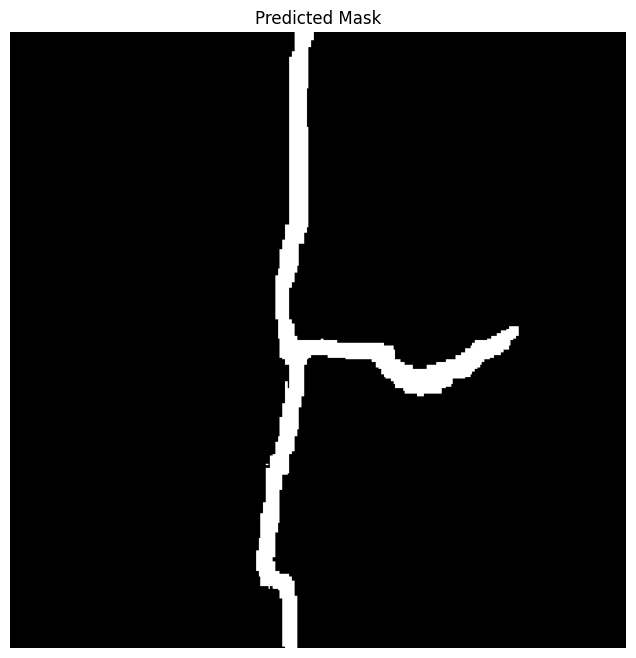

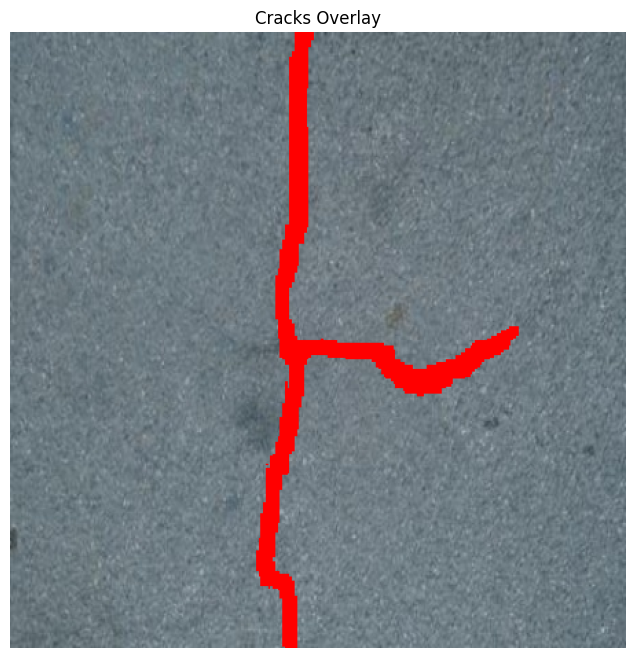

In [10]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as T
import segmentation_models_pytorch as smp

image = cv2.imread("sample3.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Resize to training size
H, W = image.shape[:2]
image_resized = cv2.resize(image, (256, 256))

# Convert to tensor and normalize with ImageNet stats
tensor = torch.from_numpy(image_resized).float().permute(2,0,1) / 255.0
normalize = T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
tensor = normalize(tensor).unsqueeze(0).to(device)  # shape (1,3,256,256)

# -----------------------------
# 3️⃣ Forward pass
# -----------------------------
with torch.no_grad():
    pred = model(tensor)          # raw logits
    pred = torch.sigmoid(pred)    # 0-1
    pred_mask = (pred > 0.5).float()  # binary mask

# Resize mask back to original image size
mask = pred_mask.squeeze().cpu().numpy()
mask_resized = cv2.resize(mask, (W, H), interpolation=cv2.INTER_NEAREST)

# -----------------------------
# 4️⃣ Show mask
# -----------------------------
plt.figure(figsize=(8,8))
plt.imshow(mask_resized, cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")
plt.show()

# -----------------------------
# 5️⃣ Overlay on original image
# -----------------------------
overlay = image.copy()
overlay[mask_resized==1] = [255,0,0]  # red for cracks

plt.figure(figsize=(8,8))
plt.imshow(overlay)
plt.title("Cracks Overlay")
plt.axis("off")
plt.show()


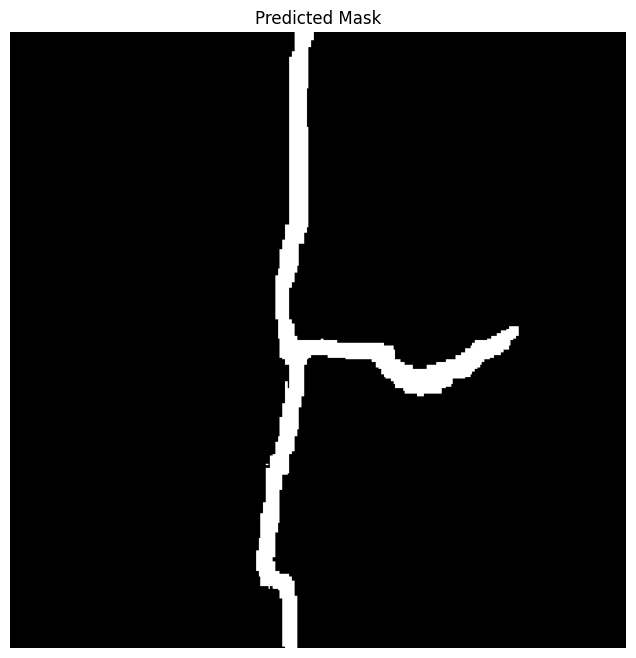

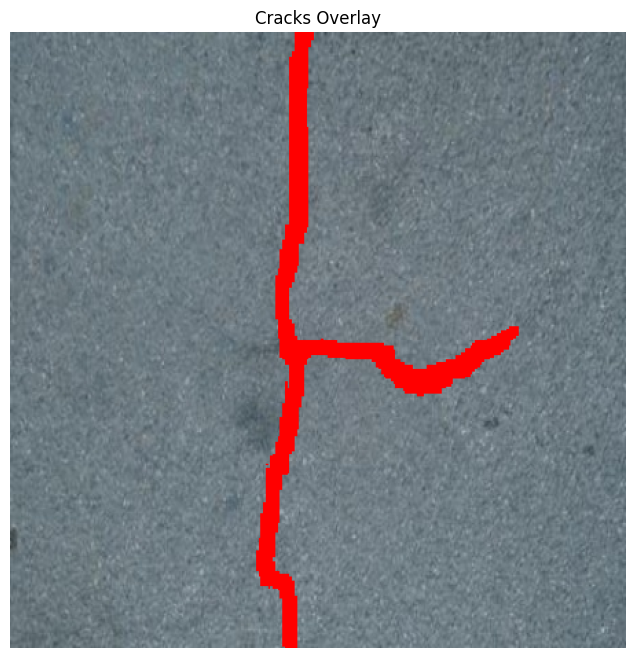

In [12]:
# -----------------------------
# 2️⃣ Load and preprocess image
# -----------------------------
def preprocess_image(image_path, target_size=(256,256)):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    H, W = image.shape[:2]

    # Resize for model input
    image_resized = cv2.resize(image, target_size)

    # Convert to tensor and normalize (ImageNet stats for pretrained encoder)
    tensor = torch.from_numpy(image_resized).float().permute(2,0,1) / 255.0
    normalize = T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
    tensor = normalize(tensor).unsqueeze(0).to(device)  # shape (1,3,H,W)

    return image, tensor, (H, W)

# -----------------------------
# 3️⃣ Run inference
# -----------------------------
def predict_mask(image_path):
    original_image, tensor, (H, W) = preprocess_image(image_path)

    with torch.no_grad():
        pred = model(tensor)               # logits
        pred = torch.sigmoid(pred)         # probabilities [0,1]
        pred_mask = (pred > 0.5).float()  # binary mask

    # Resize mask back to original size
    mask = pred_mask.squeeze().cpu().numpy()
    mask_resized = cv2.resize(mask, (W, H), interpolation=cv2.INTER_NEAREST)

    return original_image, mask_resized

# -----------------------------
# 4️⃣ Visualize results
# -----------------------------
def show_overlay(image, mask):
    plt.figure(figsize=(8,8))
    plt.imshow(mask, cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")
    plt.show()

    overlay = image.copy()
    overlay[mask==1] = [255,0,0]  # red overlay for cracks

    plt.figure(figsize=(8,8))
    plt.imshow(overlay)
    plt.title("Cracks Overlay")
    plt.axis("off")
    plt.show()

# -----------------------------
# 5️⃣ Run on sample image
# -----------------------------
img_path = "sample3.jpg"
img, mask = predict_mask(img_path)
show_overlay(img, mask)